# Game Theory for Image Segmentation (DINO version)

## Getting started

We start by loading the necessary modules and the BSDS300 dataset

In [106]:
import numpy as np
import scipy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import time

In [107]:
BERKELEY_RGB_PATH = "../data/BSDS300/dino_test/rgb_ref"
BERKELEY_IMG_PATHS = [os.path.join(BERKELEY_RGB_PATH, f) for f in os.listdir(BERKELEY_RGB_PATH) if os.path.isfile(os.path.join(BERKELEY_RGB_PATH, f))]
BERKELEY_IMG_NAMES = [os.path.splitext(f)[0] for f in os.listdir(BERKELEY_RGB_PATH) if os.path.isfile(os.path.join(BERKELEY_RGB_PATH, f))]
BERKELEY_DINO_PATH = "../data/BSDS300/dino_test/pca_64"
BERKELEY_DINO_PATHS = [os.path.join(BERKELEY_DINO_PATH, img_name + ".npy") for img_name in BERKELEY_IMG_NAMES]
BERKELEY_DINO_PATH_TILE_2 = "../data/BSDS300/dino_test_tile_2/pca_64"
BERKELEY_DINO_PATHS_TILE_2 = [os.path.join(BERKELEY_DINO_PATH_TILE_2, img_name + ".npy") for img_name in BERKELEY_IMG_NAMES]

The following functions are used to load images and process the results from the custering game

In [108]:
def load_img(img_path, scale_factor: int = 1, size=None, target_color_space=cv2.COLOR_BGR2LAB, verbose=True):
    """
    Input: image path and downscale factor
    Output: downscaled rgb image, flattened image in target color space, height H and width W
    (of the downscaled image!)
    """
    img_bgr = cv2.imread(img_path)
    H, W = img_bgr.shape[:2]
    
    # Convert to rgb
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Downscale image
    if size is not None:
        img_bgr = cv2.resize(img_bgr, (size, size))
    else:
        img_bgr = cv2.resize(img_bgr, (W // scale_factor, H // scale_factor))
    H, W = img_bgr.shape[:2]
    
    # Convert image to target
    img_target = cv2.cvtColor(img_bgr, target_color_space)
    
    if verbose:
        print(f"Loaded image {img_path} with final size ({H}, {W})")
    return img_rgb, img_target.reshape(-1, 3), H, W

In [109]:
def compute_average_colors(img, cluster_indices):
    """
    Computes the average image in the target color space with the provided cluster indices
    """
    avg_img = np.zeros_like(img)
    for cluster in cluster_indices:
        avg_img[cluster] = np.average(img[cluster], axis=0)
    return avg_img

def compute_support_img(img_target, cluster_indices):
    """
    Computes an image with a distinct integer value for each clustered pixel (starting from 1 to n_clusters)
    In case of unassigned pixels, they are mapped to 0.
    """
    support = np.zeros(len(img_target))
    for i_cluster, cluster in enumerate(cluster_indices):
        support[cluster] = i_cluster + 1
    return support

We can now introduce the color-space similarity/payoff matrix as defined in the project report

In [110]:
def rgb_gaussian_similarity(x, y, sigma=250, diag_value=0):
    """
    Creates a gaussian similarity matrix with kernel size sigma. 
    Note that the diagonal value can be enforced with diag_value (if set to None, it is disabled)
    """
    dist = scipy.spatial.distance_matrix(x, y)
    A = np.exp(-dist**2/sigma**2)
    if diag_value is not None:
        np.fill_diagonal(A, diag_value)
    return A

def extract_clusters(X, population_threshold=1e-6):
    """
    Extracts the clusters based on the provided threshold and returns the selected RELATIVE ids
    """
    return np.nonzero(X > population_threshold)

We add a simple sampling algorithm to select a subset of pixels on which to run the dynamics in the target image

In [111]:
def random_sampling(PID, p=0.01):
    n = len(PID)
    k = int(n*p)
    in_samples = np.sort(np.random.choice(PID, k, replace=False))
    out_samples = np.setdiff1d(PID, in_samples)
    return in_samples, out_samples

Finally, we use additional utility functions to display side-by-side the results of the segmentation or save it at the given path

In [112]:
def display_all_images(img_rgb, img_target, H, W, cluster_indices, color_space=cv2.COLOR_LAB2RGB, cmap="Set2"):
    """
    Displays side-by-side of rgb image, segmented image and averaged image w.r.t. the segments
    """
    support = compute_support_img(img_target, cluster_indices)
    support = support.reshape(H, W)

    avg_img = compute_average_colors(img_target, cluster_indices)
    avg_img = avg_img.reshape(H, W, 3)
    avg_img = cv2.cvtColor(avg_img, color_space)
    
    plt.figure()
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original")
    axs[1].imshow(support, cmap=cmap)
    axs[1].set_title("Clusters")
    axs[2].imshow(avg_img)
    axs[2].set_title("Averaged")
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [113]:
def save_clustering(img_rgb, img_target, H, W, cluster_indices, target_path, img_name, color_space=cv2.COLOR_LAB2BGR, cmap="Set2"):
    """
    Saves segmented image and averaged image w.r.t. the segments
    """
    # Create directory
    os.makedirs(target_path, exist_ok=True)
    
    support = compute_support_img(img_target, cluster_indices)
    support = support.reshape(H, W)
    plt.imsave(os.path.join(target_path, f"{img_name}_seg.png"), support, cmap=cmap)
    
    avg_img = compute_average_colors(img_target, cluster_indices)
    avg_img = avg_img.reshape(H, W, 3)
    avg_img = cv2.cvtColor(avg_img, color_space)
    cv2.imwrite(os.path.join(target_path, f"{img_name}_avg.png"), avg_img)

In [114]:
def best_response_update(A, X, t, g, expected_payoff, r):
    """
    Input: similarity matrix A, strategy distribution X, time step t,
    expected payoff vector, expected payoff of population X and expected payoff of pure strategies
    Output: new distribution of strategies X_{t+1} according to best response dynamics
    """
    best_id = np.argmax(g)
    best_vector = np.zeros(len(X))
    best_vector[best_id] = 1.
    # Update population according to best response dynamics
    return (best_vector - X) / (t + 1) + X

In [115]:
def cluster_game(img, algorithm=best_response_update, similarity=rgb_gaussian_similarity, sampling_alg=random_sampling, max_segments=8, max_iter=5000, nash_tol=1e-3):
    """
    Input: 
        - target image (flattened)
        - algorithm used for the evolutionary dynamics
        - similarity matrix function
        - algorithm used to sample a subset of pixels
        - maximum number of segments
        - maximum number of iterations 
        - nash tolerance epsilon 
    Output: 
        - new distribution of strategies X_{t+1} according to best response dynamics
    """
    segment_trajectories = []
    cluster_indices = []
    out_cluster_indices = []
    
    start_time = time.time()
    
    eps_square = nash_tol**2

    # Initialize color array (with all pixels)
    C = img.copy()
    # Initialize array of indices to keep track of pixels as we prune things from segments to segments
    PID = np.arange(len(C))
    
    # Extract subset of pixels according to the sampling algorithm
    PID, out_PID = sampling_alg(PID)
    out_C = C[out_PID]
    C = C[PID]

    for segment in range(max_segments):
        # Set the new number of objects for this segment
        n = len(C)
        if n == 0:
            break
        # Initialize population and similarity matrix
        X = 1. / n *  np.ones(n)
#         print(C.shape)
        A = similarity(C, C)

        trajectories = [X]

        # TODO: stop iteration if we reach a threshold
        for t in range(1, max_iter+1):
            g = A@X
            expected_payoff = X.T@g
            r = g - expected_payoff*np.ones(X.shape[0])
            if np.sum(np.minimum(X, -r)**2) <= eps_square:
#                 print(t)
                break
            # Update population according to best response dynamics
            X = algorithm(A, X, t, g, expected_payoff, r)
            # Store the current state in the trajectory
            trajectories.append(X.copy())

        # Collect clusters   
        new_clusters = extract_clusters(X)
        cluster_indices.append(PID[new_clusters])
        
        # Collect clusters among out of sample with dominant set attribution
        if len(out_C) > 0:
            cluster_X = X[new_clusters]
            cluster_C = C[new_clusters]
            cluster_A = similarity(out_C, cluster_C, diag_value=None)
            w_Si = cluster_A@cluster_X 
            expected_payoff = X.T@A@X
            out_new_clusters = np.nonzero(w_Si > expected_payoff)[0]
    #         print(out_new_clusters.shape)
            out_cluster_indices.append(out_PID[out_new_clusters])
            out_C = np.delete(out_C, out_new_clusters, axis=0)
            out_PID = np.delete(out_PID, out_new_clusters)

            cluster_indices[-1] = np.union1d(cluster_indices[-1], out_cluster_indices[-1])
        
        # Update feature and id matrices
        C = np.delete(C, new_clusters, axis=0)
        PID = np.delete(PID, new_clusters)

        # Store segment trajectory
        segment_trajectories.append(trajectories)
        
    # Add the remaining pixels to one cluster (if not all allocated)
    if len(PID) > 0 or len(out_PID) > 0:
        cluster_indices.append(PID)
        out_cluster_indices.append(out_PID)
        cluster_indices[-1] = np.union1d(cluster_indices[-1], out_cluster_indices[-1])
    
    return cluster_indices, segment_trajectories, time.time() - start_time

In [116]:
def replicator_dynamics_update(A, X, t, g, expected_payoff, r, kappa=0.):
    """
    Input: similarity matrix A, strategy distribution X, time step t,
    expected payoff vector, expected payoff of population X and expected payoff of pure strategies
    Output: new distribution of strategies X_{t+1} according to replicator dynamics
    """
    # Update population according to replicator dynamics
    X_new = X*(g + kappa) / (expected_payoff + kappa)
    return X_new

In [117]:
def pure_inimdyn_update(A, X, t, g, expected_payoff, r, support_threshold=1e-6):
    """
    Input: similarity matrix A, strategy distribution X, time step t,
    expected payoff vector, expected payoff of population X and expected payoff of pure strategies
    Output: new distribution of strategies X_{t+1} according to Pure InImDyn
    """
    # Compute argmax r_z
    i = np.argmax(r)
    # Compute argmin_{sigma_x} r_z
    r_tmp = r.copy()
    r_tmp[X <= support_threshold] = r.max()
    j = np.argmin(r_tmp)
    # Select actual index
#     print(r[i])
    if r[i] < -r[j]:
        i = j    
    # Compute the denominator of delta
    den = A[i, i] - g[i] - r[i]
    if r[i] > 0:
        delta = 1
        if den < 0:
            delta = min(delta, -r[i]/den)
    else:
        delta = X[i] / (X[i] - 1)
        if den < 0:
            delta = max(delta, -r[i]/den)
    # Update X
    e_i = np.zeros(X.shape[0])
    e_i[i] = 1.
    X_new = delta*(e_i - X) + X
    return X_new

In [119]:
def dino_cosine_similarity(x, y, T=25., diag_value=0.):
    similarity = cosine_similarity(x, y)
    A = np.exp(-(1 - similarity)/T)
    if diag_value is not None:
        np.fill_diagonal(A, diag_value)
    return A
dino_similarity = lambda x, y, diag_value=0: dino_cosine_similarity(x, y, T=25.)

Results for 1 tile

Loaded image ../data/BSDS300/dino_test/rgb_ref/361010.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

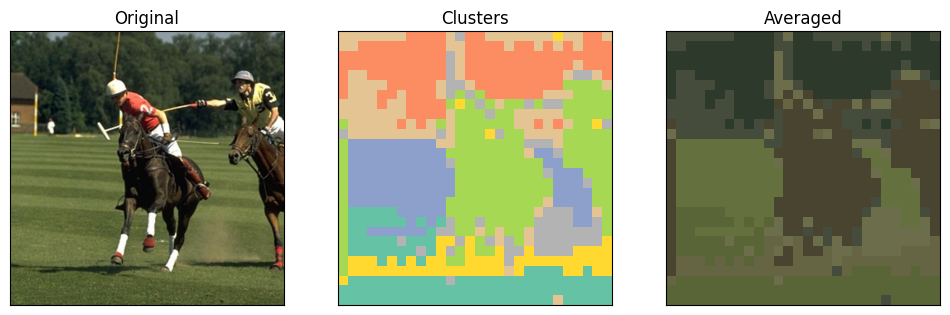

Loaded image ../data/BSDS300/dino_test/rgb_ref/102061.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

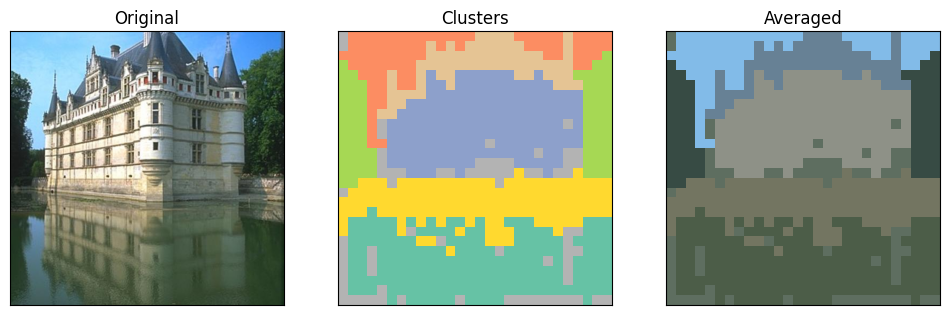

Loaded image ../data/BSDS300/dino_test/rgb_ref/196073.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

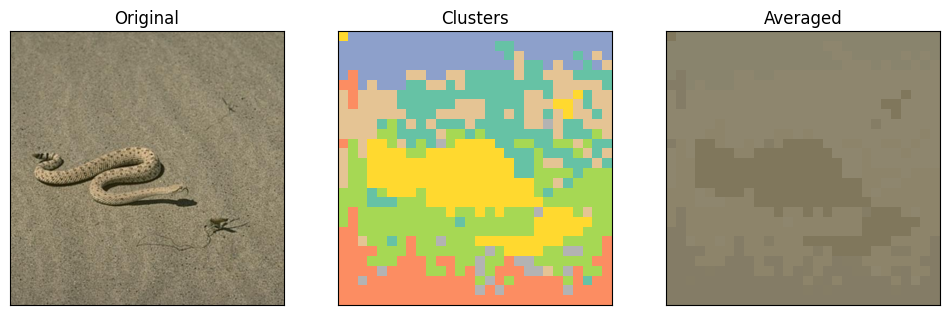

Loaded image ../data/BSDS300/dino_test/rgb_ref/148026.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

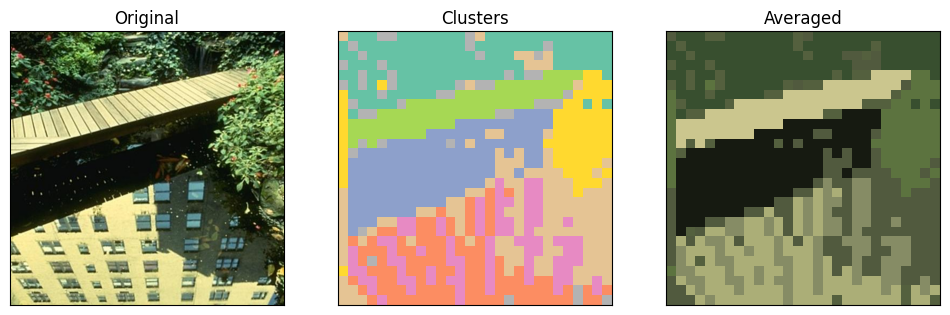

Loaded image ../data/BSDS300/dino_test/rgb_ref/33039.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

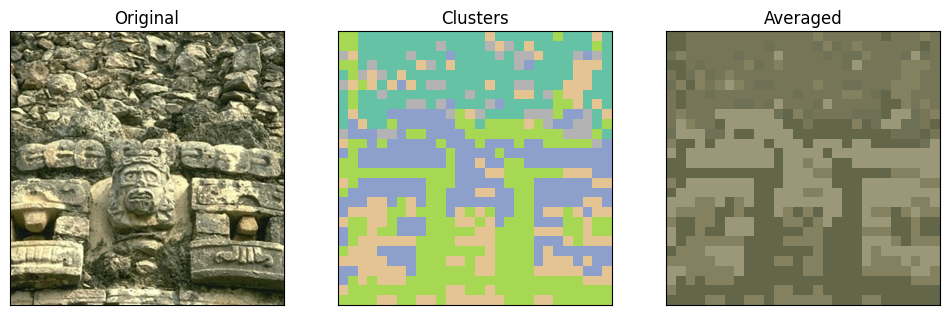

Loaded image ../data/BSDS300/dino_test/rgb_ref/89072.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

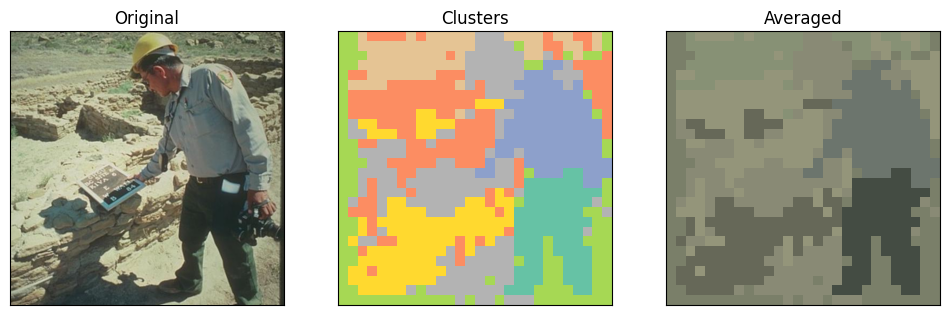

Loaded image ../data/BSDS300/dino_test/rgb_ref/376043.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

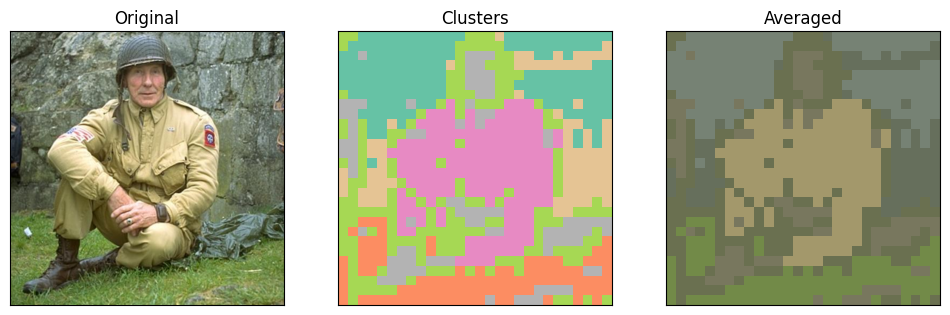

Loaded image ../data/BSDS300/dino_test/rgb_ref/38092.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

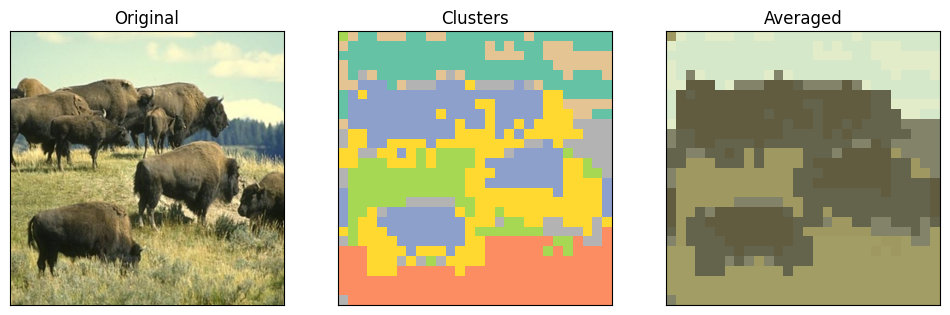

Loaded image ../data/BSDS300/dino_test/rgb_ref/16077.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

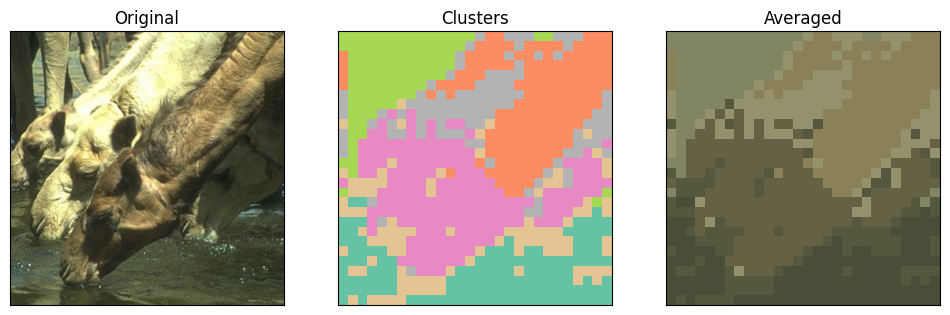

Loaded image ../data/BSDS300/dino_test/rgb_ref/103070.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

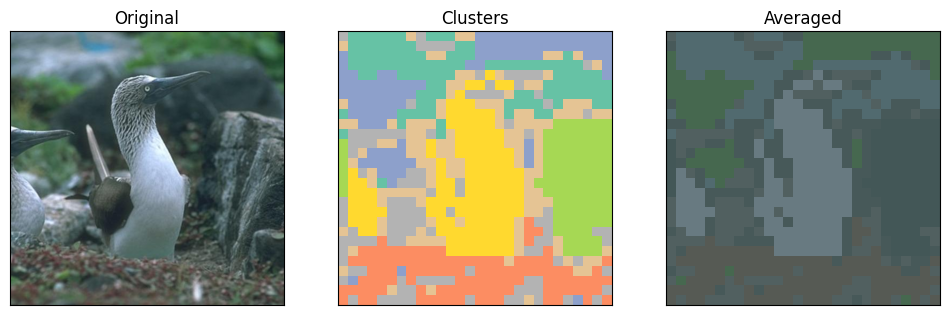

Loaded image ../data/BSDS300/dino_test/rgb_ref/219090.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

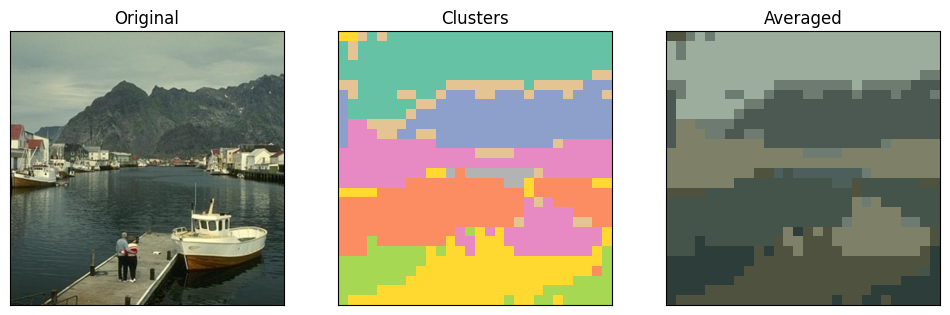

Loaded image ../data/BSDS300/dino_test/rgb_ref/41033.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

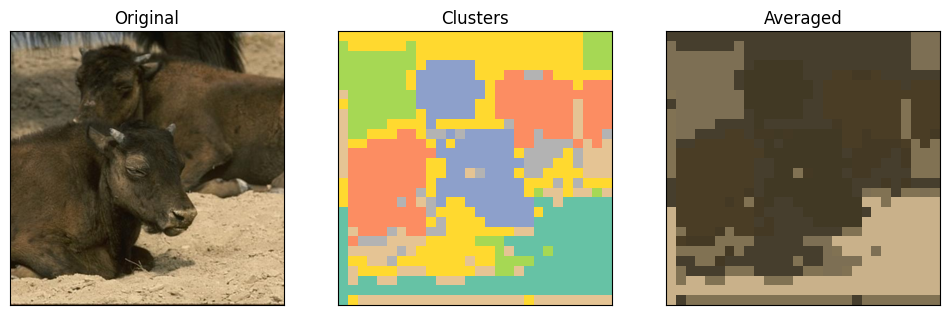

Loaded image ../data/BSDS300/dino_test/rgb_ref/97033.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

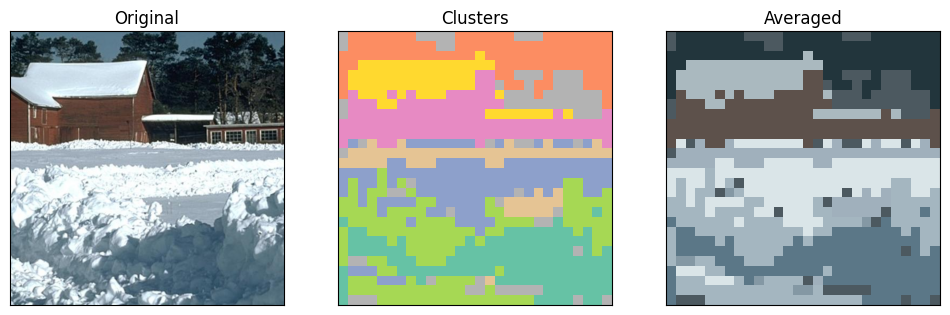

Loaded image ../data/BSDS300/dino_test/rgb_ref/143090.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

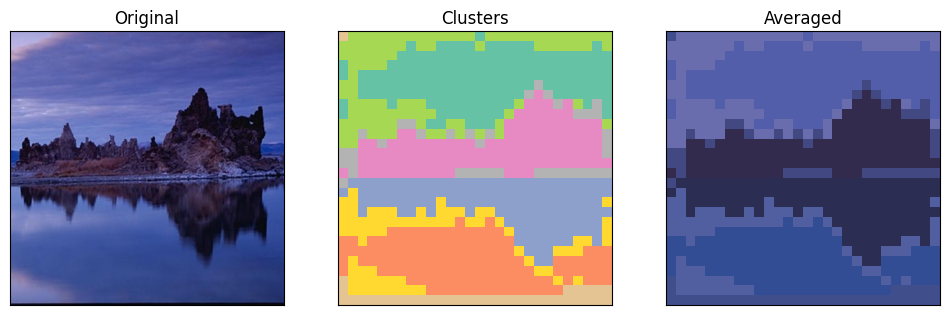

Loaded image ../data/BSDS300/dino_test/rgb_ref/156065.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

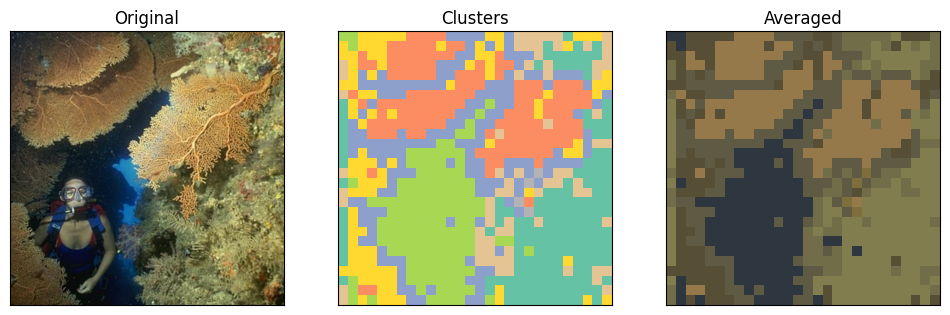

Loaded image ../data/BSDS300/dino_test/rgb_ref/108070.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

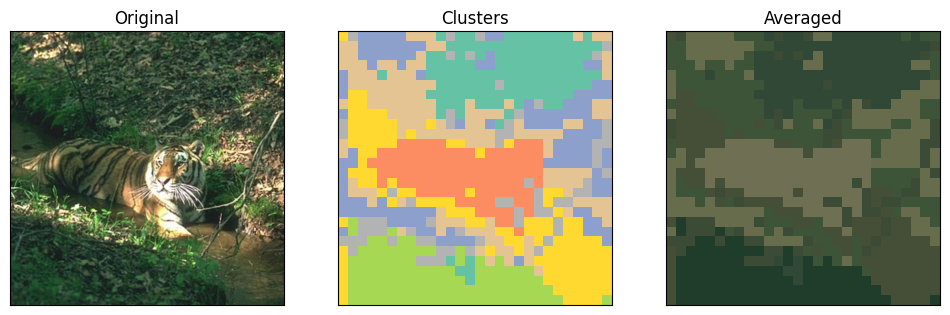

Loaded image ../data/BSDS300/dino_test/rgb_ref/260058.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

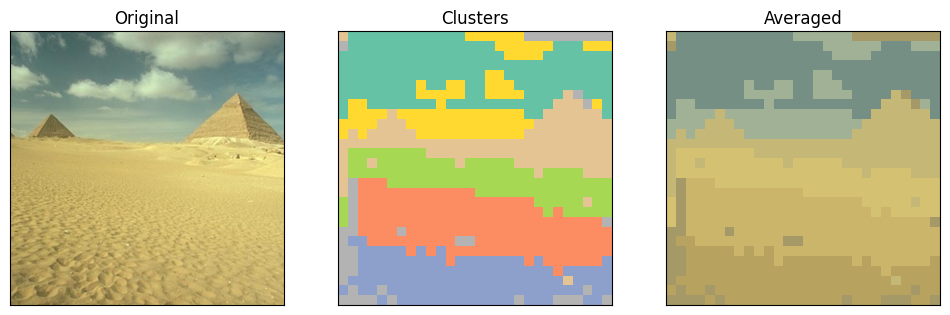

Loaded image ../data/BSDS300/dino_test/rgb_ref/62096.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

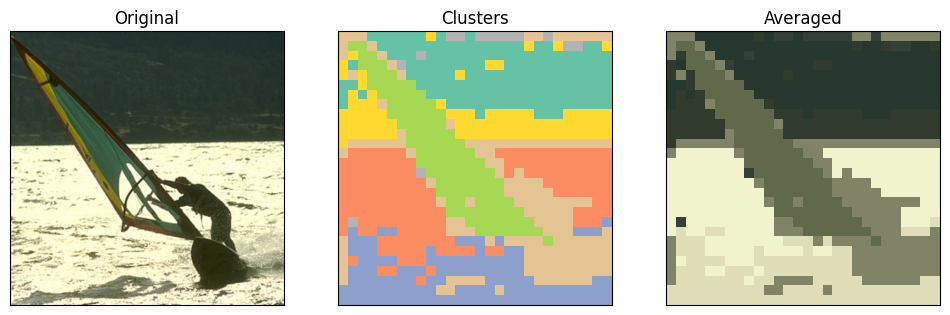

Loaded image ../data/BSDS300/dino_test/rgb_ref/87046.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

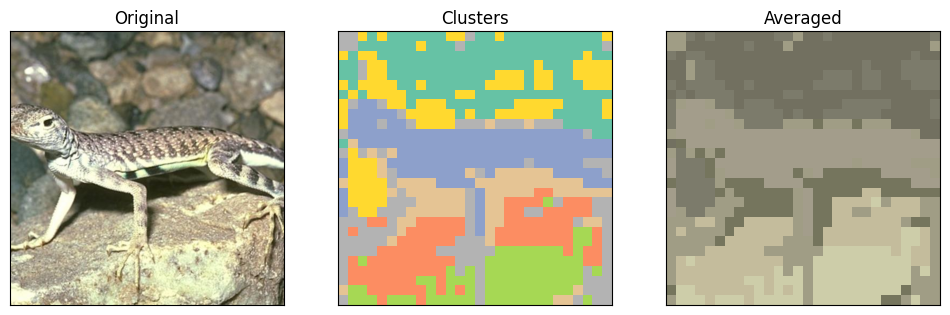

Loaded image ../data/BSDS300/dino_test/rgb_ref/285079.jpg with final size (28, 28)


<Figure size 640x480 with 0 Axes>

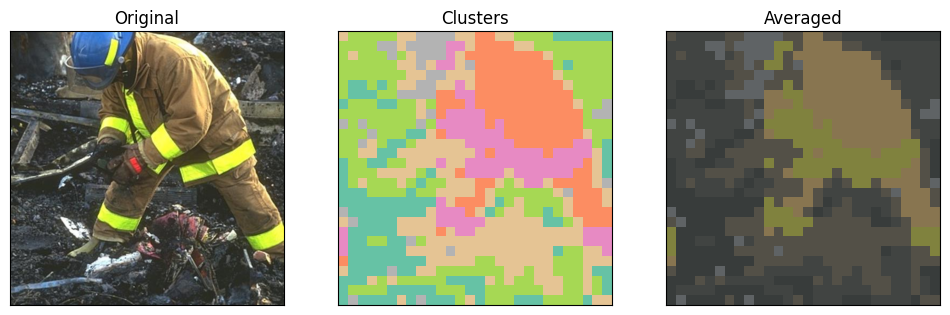

In [122]:
# dino_similarity = lambda x, y: dino_cosine_similarity(x, y)
sampling_alg = lambda x: (np.arange(len(x)), np.zeros(0, dtype=int))
for i_img, img_path in enumerate(BERKELEY_IMG_PATHS[0:20]):
    img_rgb, img_target, H, W = load_img(BERKELEY_IMG_PATHS[i_img], size=28)
    img_dino = np.load(BERKELEY_DINO_PATHS[i_img])
    cluster_indices, segment_trajectories, _ = cluster_game(img_dino, algorithm=pure_inimdyn_update, similarity=dino_similarity, sampling_alg=sampling_alg)
    
    display_all_images(img_rgb, img_target, H, W, cluster_indices)

Results for 4 tiles

Loaded image ../data/BSDS300/dino_test/rgb_ref/361010.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

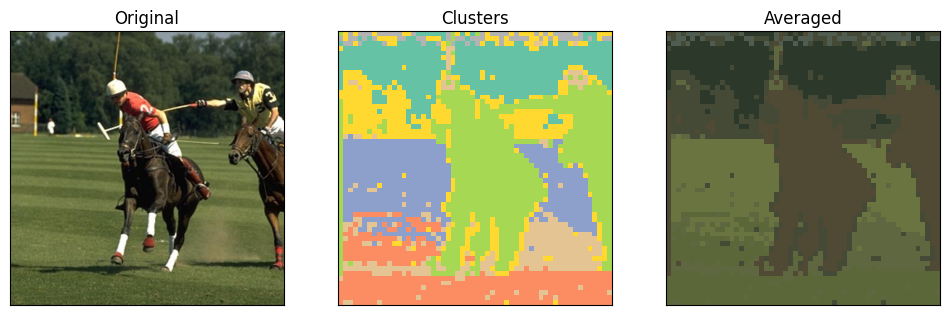

Loaded image ../data/BSDS300/dino_test/rgb_ref/102061.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

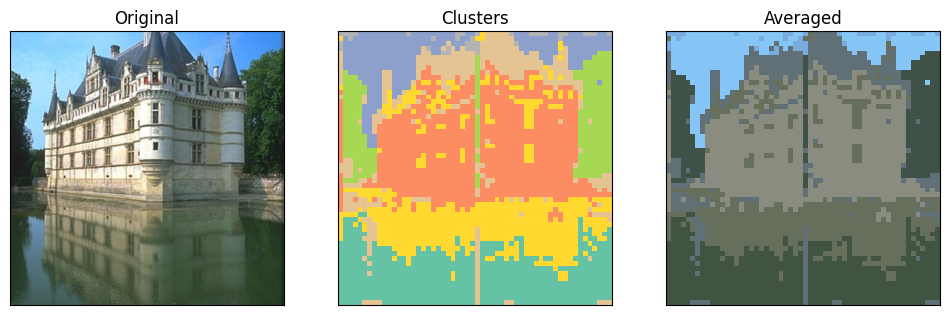

Loaded image ../data/BSDS300/dino_test/rgb_ref/196073.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

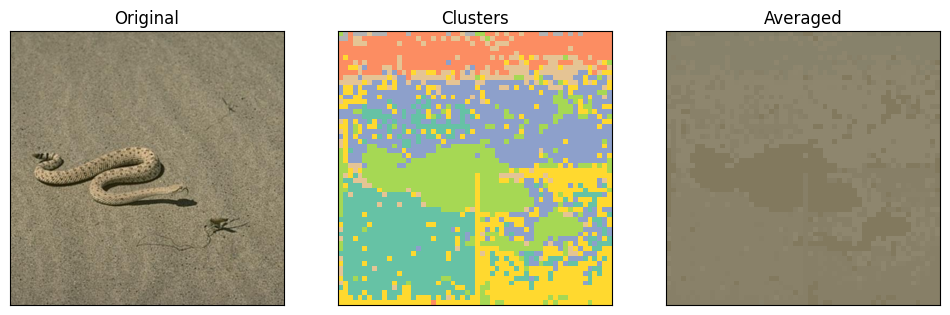

Loaded image ../data/BSDS300/dino_test/rgb_ref/148026.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

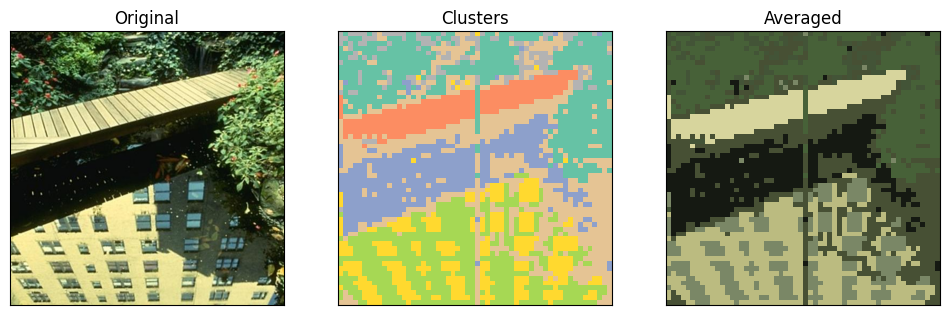

Loaded image ../data/BSDS300/dino_test/rgb_ref/33039.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

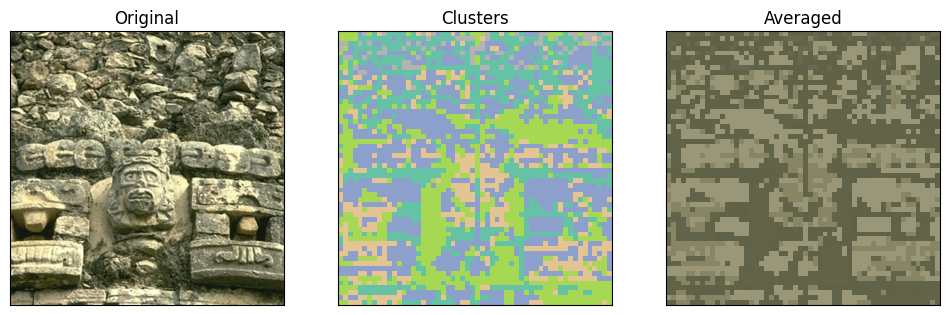

Loaded image ../data/BSDS300/dino_test/rgb_ref/89072.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

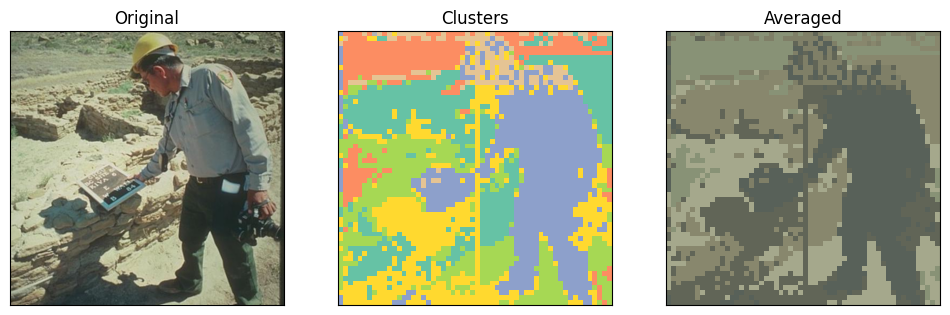

Loaded image ../data/BSDS300/dino_test/rgb_ref/376043.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

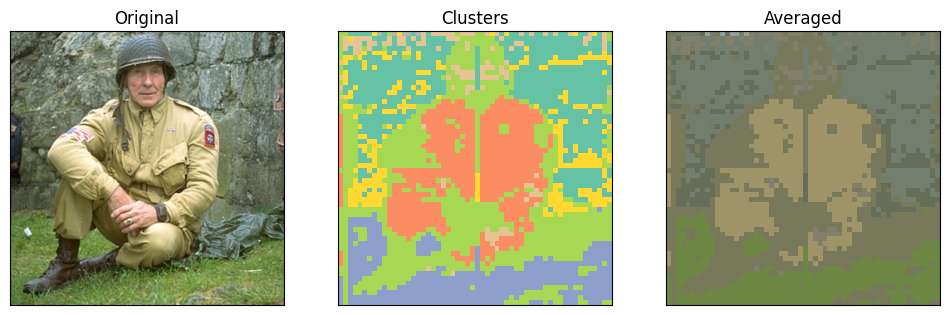

Loaded image ../data/BSDS300/dino_test/rgb_ref/38092.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

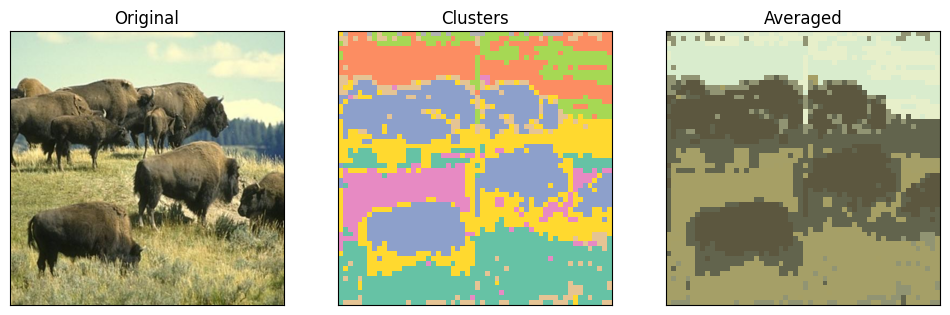

Loaded image ../data/BSDS300/dino_test/rgb_ref/16077.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

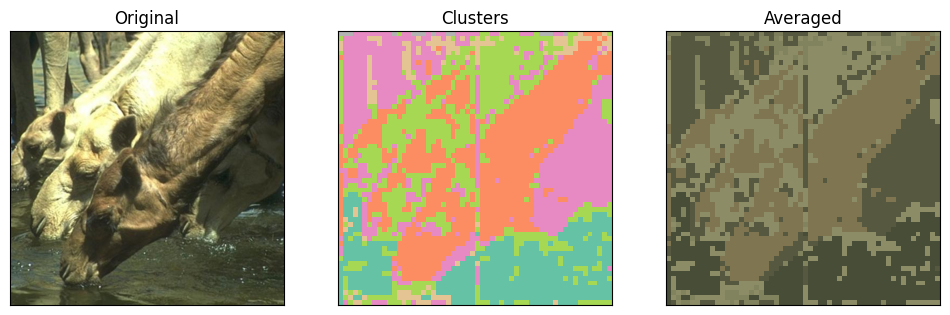

Loaded image ../data/BSDS300/dino_test/rgb_ref/103070.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

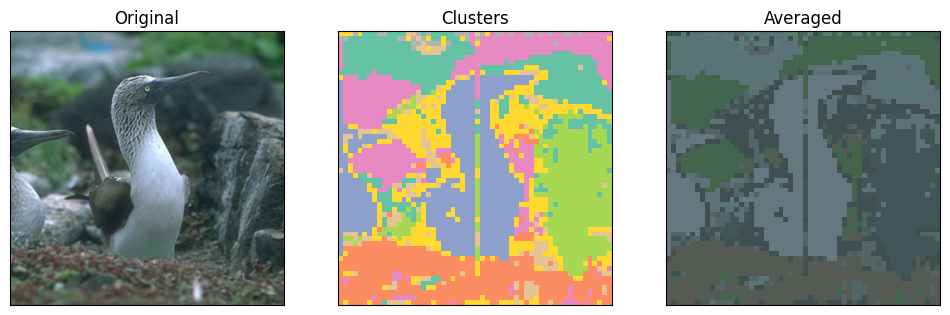

Loaded image ../data/BSDS300/dino_test/rgb_ref/219090.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

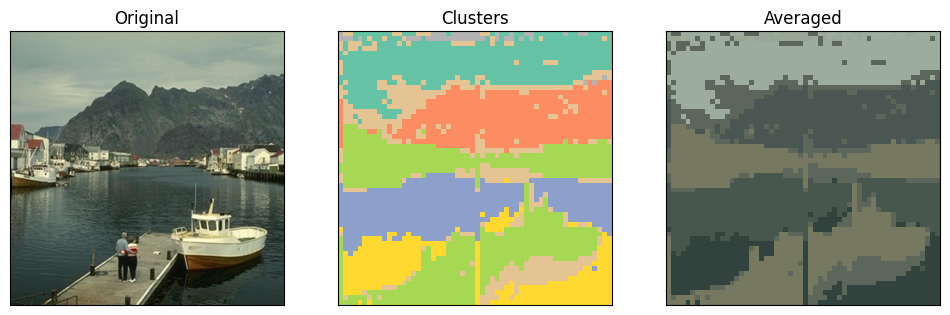

Loaded image ../data/BSDS300/dino_test/rgb_ref/41033.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

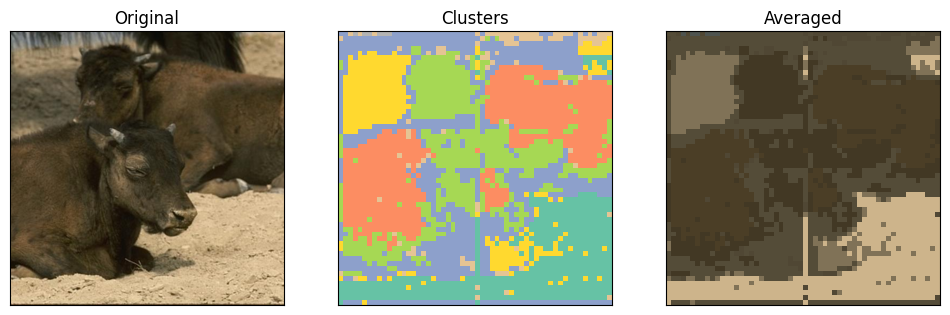

Loaded image ../data/BSDS300/dino_test/rgb_ref/97033.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

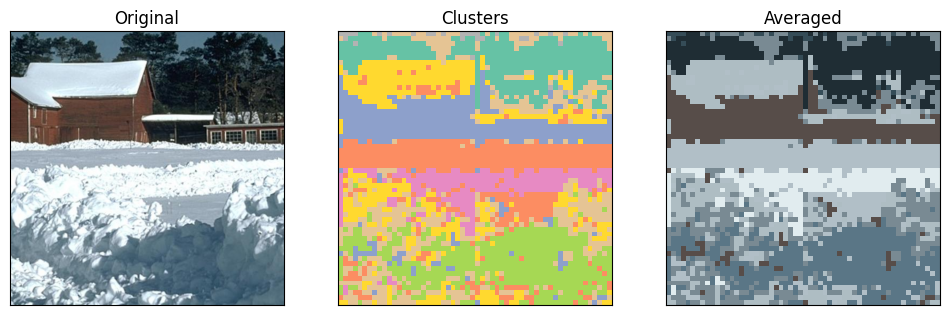

Loaded image ../data/BSDS300/dino_test/rgb_ref/143090.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

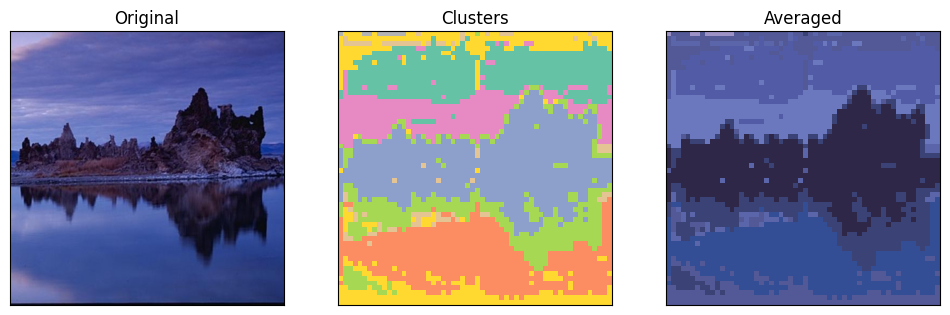

Loaded image ../data/BSDS300/dino_test/rgb_ref/156065.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

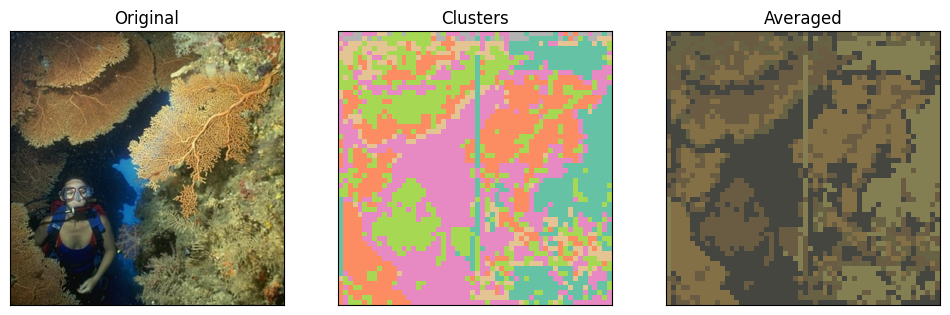

Loaded image ../data/BSDS300/dino_test/rgb_ref/108070.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

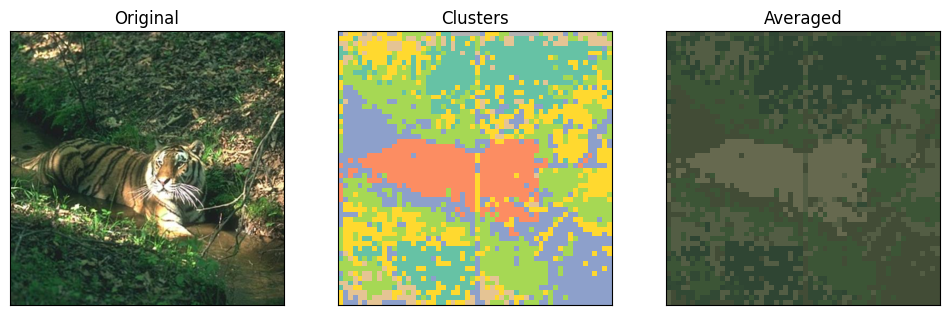

Loaded image ../data/BSDS300/dino_test/rgb_ref/260058.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

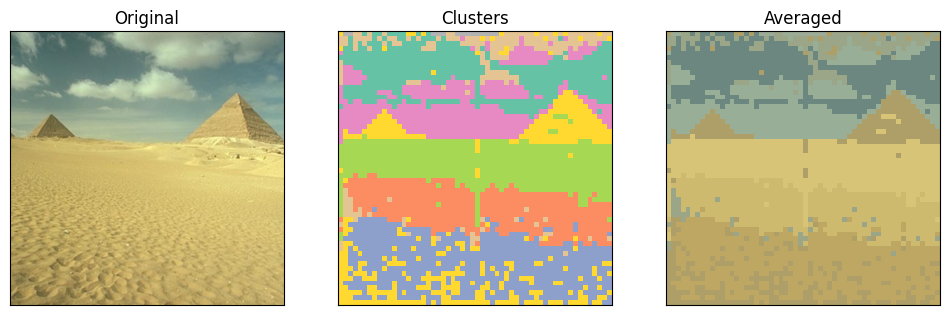

Loaded image ../data/BSDS300/dino_test/rgb_ref/62096.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

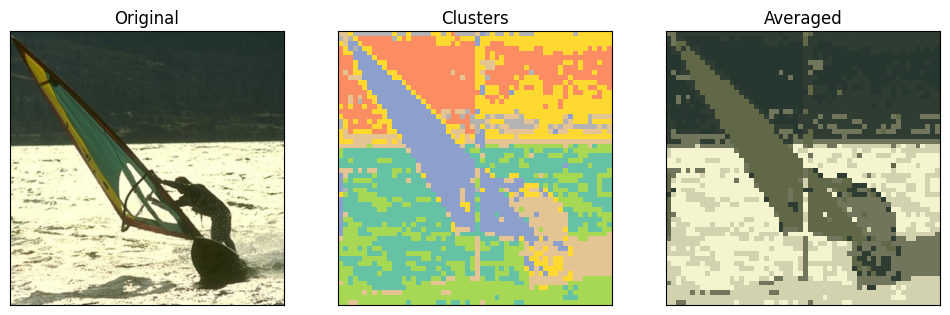

Loaded image ../data/BSDS300/dino_test/rgb_ref/87046.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

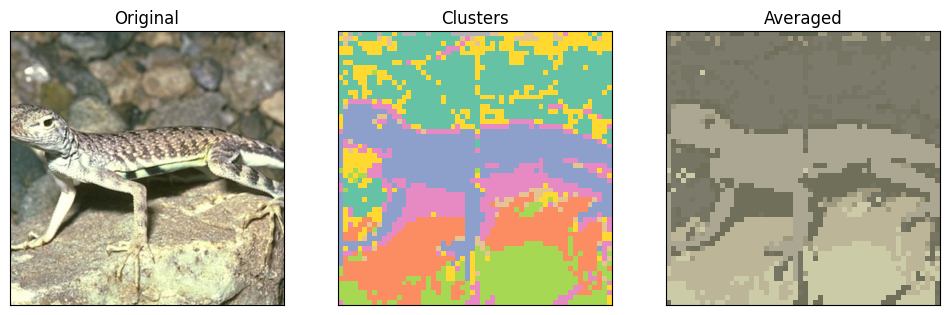

Loaded image ../data/BSDS300/dino_test/rgb_ref/285079.jpg with final size (56, 56)


<Figure size 640x480 with 0 Axes>

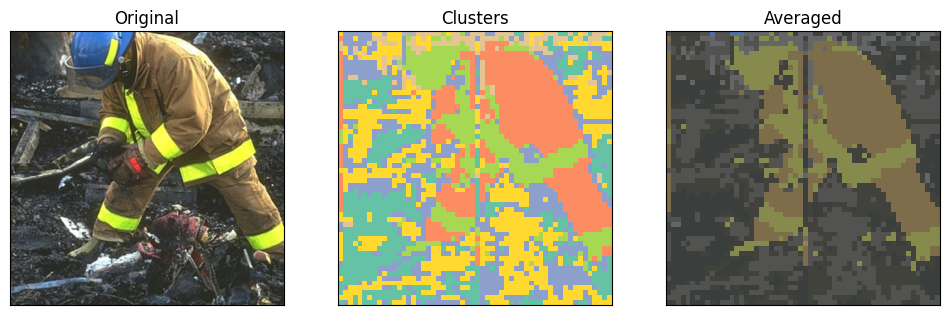

In [123]:
# dino_similarity = lambda x, y: dino_cosine_similarity(x, y)
sampling_alg = lambda x: random_sampling(x, p=0.25)
for i_img, img_path in enumerate(BERKELEY_IMG_PATHS[0:20]):
    img_rgb, img_target, H, W = load_img(BERKELEY_IMG_PATHS[i_img], size=56)
    img_dino = np.load(BERKELEY_DINO_PATHS_TILE_2[i_img])
    cluster_indices, segment_trajectories, _ = cluster_game(img_dino, algorithm=pure_inimdyn_update, similarity=dino_similarity, sampling_alg=sampling_alg)
    
    display_all_images(img_rgb, img_target, H, W, cluster_indices)

## Collecting all data on the testing set of BSDS300

In [ ]:
sampling_alg = lambda x: (np.arange(len(x)), np.zeros(0, dtype=int))
for i_img, img_path in tqdm(enumerate(BERKELEY_IMG_PATHS)):
    img_rgb, img_target, H, W = load_img(BERKELEY_IMG_PATHS[i_img], size=28, verbose=False)
    img_dino = np.load(BERKELEY_DINO_PATHS[i_img])
    cluster_indices, segment_trajectories, _ = cluster_game(img_dino, algorithm=pure_inimdyn_update, similarity=dino_similarity, sampling_alg=sampling_alg)
    
    save_clustering(img_rgb, img_target, H, W, cluster_indices, f"../experiments/bsds300_test_dino_64/inimdyn/", BERKELEY_IMG_NAMES[i_img])

    trajectories = np.array(segment_trajectories[0])
    n_iter = len(trajectories)
    plt.figure()
    for i_traj in range(trajectories.shape[1]):
        plt.plot(np.arange(n_iter), trajectories[:, i_traj])
    plt.savefig(os.path.join(f"../experiments/bsds300_test_dino_64/inimdyn/", BERKELEY_IMG_NAMES[i_img] + "_traj.pdf"))

In [ ]:
sampling_alg = lambda x: random_sampling(x, p=0.25)
for i_img, img_path in tqdm(enumerate(BERKELEY_IMG_PATHS)):
    img_rgb, img_target, H, W = load_img(BERKELEY_IMG_PATHS[i_img], size=56, verbose=False)
    img_dino = np.load(BERKELEY_DINO_PATHS_TILE_2[i_img])
    cluster_indices, segment_trajectories, _ = cluster_game(img_dino, algorithm=pure_inimdyn_update, similarity=dino_similarity, sampling_alg=sampling_alg)
    
    save_clustering(img_rgb, img_target, H, W, cluster_indices, f"../experiments/bsds300_test_tile_2_dino_64/inimdyn/", BERKELEY_IMG_NAMES[i_img])